# Complex trace attributes

A normal seismic display shows **amplitude**, with the phase and frequency implicitly determining, along with geology, how the amplitude is distributed for a given acquisition and processing experiment. In this notebook, we look at a family of attributes related to the **complex trace**.

Art Barnes is required reading before jumping into seismic attributes! Read this: https://csegrecorder.com/articles/view/too-many-seismic-attributes

Barnes (2016) is also worth reading. Here's his account of the complex trace:

> The essence of complex seismic trace analysis lies in the separation of amplitude information from phase information in seismic data. This idea is inspired by the example of Fourier analysis. Fourier frequency transforms are represented either in Cartesian form as cosine and sine spectra, or in polar form as amplitude and phase spectra. Cosine and sine spectra are natural products of the Fourier transform, but amplitude and phase spectra are better suited for physical studies. [...]

> Just as Fourier transforms are represented in terms of amplitude and phase spectra,
so too can seismic traces be represented with analogous amplitude and phase attributes.
To accomplish this, complex trace analysis introduces a quadrature trace derived from
the seismic trace (Cohen, 1995; Vakman, 1998). The seismic and quadrature traces are
analogous to the cosine and sine spectra in Fourier analysis, with the essential difference
that the quadrature trace depends on the real trace, whereas the cosine and sine spectra
are independent. A further difference, implied in the derivation of the quadrature trace,
is that generally the seismic trace should not have a dc component. Complex trace
amplitude and phase attributes prove as useful as their Fourier counterparts.


## Load some seismic data

We'll use 1000 ms of the F3 seismic dataset. It's 459MB, sampled at 4 ms.

To get the data on Mac or Linux you can do this right from a Jupyter Notebook:

    ! wget -O ../data/F3_16-bit_int.sgy https://geocomp.s3.amazonaws.com/data/F3_16-bit_int.sgy

On Windows, you can [visit the URL by clicking here](https://geocomp.s3.amazonaws.com/data/F3_16-bit_int.sgy) (which will download the file) then move it to the `data` directory.

In [2]:
import segyio
import numpy as np

ds = np.DataSource('../data')  # <- Local target.

url = 'https://geocomp.s3.amazonaws.com/data/F3_8-bit_int.sgy'

with segyio.open(ds.open(url).name) as s:
    seismic = segyio.cube(s)
    
# Volume is int16. Turn it into floats.
seismic = (seismic / np.max(np.abs(seismic))).astype(np.float32)
    
seismic.shape

(225, 300, 463)

In [3]:
ma = np.percentile(seismic, 99.95)

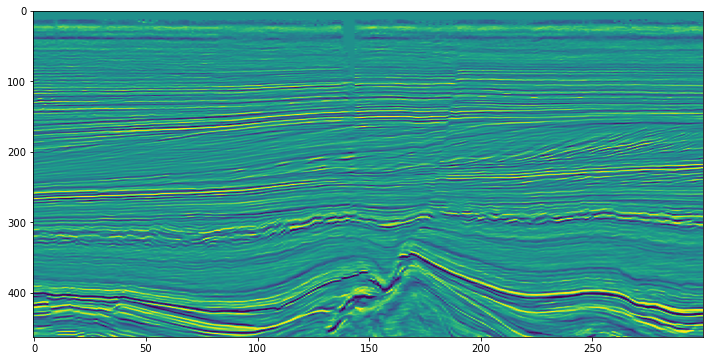

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(seismic[100].T, aspect='auto', vmin=-ma, vmax=ma)

---

## A note about `bruges`

All of these attributes are built into [`bruges`](https://github.com/agilescientific/bruges). They work on data with any number of dimensions, just ensure that time is on the last axis. You can install `bruges` with:

    pip install bruges

Here's how to use them:

```python
import bruges as bg

env = bg.attribute.envelope(seismic)
phase = bg.attribute.instantaneous_phase(seismic)
freq = bg.attribute.instantaneous_frequency(seismic)
```

---

## The complex trace

The general idea is that the **seismic trace** $x(t)$ is the product of instantaneous amplitude $a_i(t)$ (aka reflection strength), and the cosine of instantaneous phase $\theta_i(t)$. The **quadrature trace** $y(t)$ is the product of amplitude and the sine of the phase. Then the **complex trace** $z(t) = x(t) + i y(t)$. 

The complex trace is computable as the Hilbert transform of the seismic trace. This gives us access to the instantaneous amplitude and phase.

Start with a single trace:

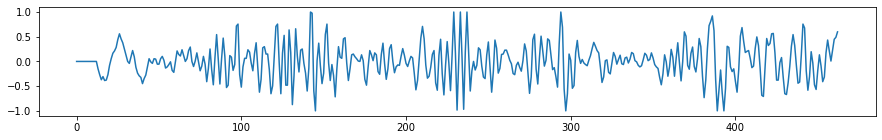

In [5]:
tr = seismic[100, 200]

fig, ax = plt.subplots(figsize=(15, 2))
ax.plot(tr)

In [6]:
from scipy.signal import hilbert

h = hilbert(tr)

h

array([-2.95931269e-08+4.81382731e-01j,  1.07995721e-07+1.32001681e-01j,
        8.96905010e-08+1.92882666e-01j,  6.15630325e-08+8.62193000e-02j,
       -1.31090265e-07+1.32294144e-01j, -8.74870798e-08+7.04086524e-02j,
        1.19640334e-07+1.11582714e-01j,  4.47160224e-08+6.78026342e-02j,
        5.89255324e-08+1.10337414e-01j,  1.19485409e-07+7.68847229e-02j,
        7.31710327e-08+1.31102530e-01j,  5.58332159e-08+1.07829389e-01j,
       -3.55570675e-08+2.30270748e-01j, -1.49606196e-01+2.50213935e-01j,
       -2.67716535e-01+2.23106717e-01j, -3.70078775e-01+5.87550521e-02j,
       -3.07086571e-01-1.85034208e-02j, -3.85826709e-01-7.45472006e-02j,
       -3.77952739e-01-2.57356709e-01j, -2.67716547e-01-4.10024244e-01j,
       -7.87401915e-02-4.68178878e-01j,  5.51181684e-02-4.36204370e-01j,
        1.65354293e-01-3.84278848e-01j,  2.12598384e-01-3.25058887e-01j,
        2.83464570e-01-3.24871907e-01j,  4.40944832e-01-2.74478752e-01j,
        5.59054995e-01-4.81696307e-02j,  4.56692925

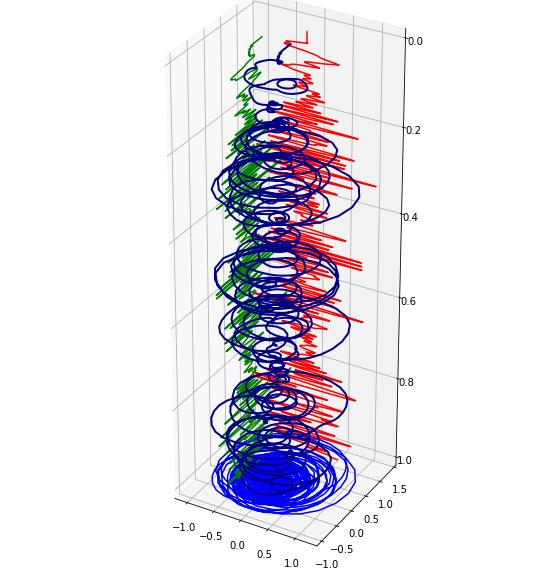

In [7]:
plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.set_box_aspect((1, 1, 3)) 

t = np.linspace(0, 1.0, tr.size)
t_new = np.arange(0, 1.0001, 0.0005)

from scipy.interpolate import interp1d

real = interp1d(t, h.real, kind='cubic')(t_new)
quad = interp1d(t, h.imag, kind='cubic')(t_new)
time = t_new

ax.plot3D(real, quad, time, 'navy', lw=2, zorder=3)
ax.plot3D(-0.5*np.ones_like(real), quad, time, 'g', zorder=2)  # Quadrature.
ax.plot3D(real, quad, np.ones_like(time), 'b', zorder=1)       # Real trace.
ax.plot3D(real, np.ones_like(quad), time, 'r', zorder=0)
ax.set_zlim3d(1, 0)
plt.show()

### EXERCISE

The instantaneous amplitude, aka envelope or reflection strength, is the _magnitude_ or _absolute value_ of the complex trace. Compute and plot this.

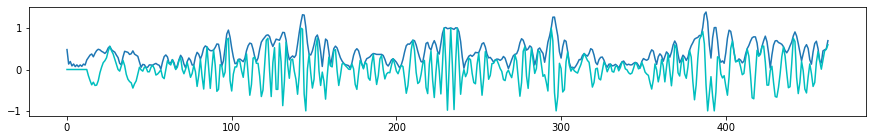

In [8]:
env = np.abs(h)

fig, ax = plt.subplots(figsize=(15, 2))
ax.plot(env)
ax.plot(tr, c='c')

It should look kind of low-frequency, and not oscillate around zero like the seismic does. [Read more about the envelope.](https://agilescientific.com/blog/2011/3/23/e-is-for-envelope.html)

Importantly, this view of the amplitude data is useful because it is independent of the phase. So if we rotate the phase, the envelope does not change:

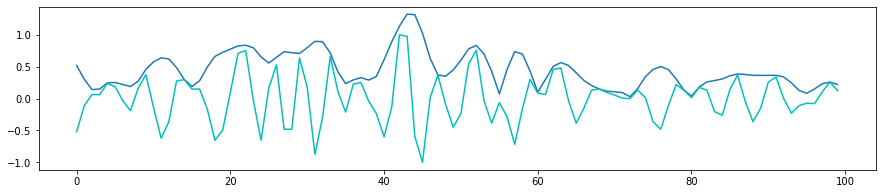

In [9]:
import bruges as bg

tr_rot = bg.filters.rotate_phase(tr, 45)

h_rot = hilbert(tr_rot)
# Add new envelope.


sel = slice(100, 200)

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(env[sel])
#ax.plot(env_rot[sel], '--')
ax.plot(tr[sel], c='c')
#ax.plot(tr_rot[sel])

### EXERCISE

Zoom in on part of the trace, and add a slider to vary the phase. (You don't need to recompute the envelope, now that you know it's phase independent.)

If you can, add a slider to choose the trace in each direction as well.

Compute the envelope attribute on the entire cube first.

Recall that you can make any function interactive with `ipywidgets`:

    from ipywidgets import interact

    @interact(a=(10, 100, 10), b=(100, 1000, 100))
    def add(a, b):
        print(f"a + b = {a + b}")

In [10]:
env = np.abs(hilbert(seismic))

In [15]:
from ipywidgets import interact

@interact(phi=(-180, 180, 5), inline=(0, 225, 10), xline=(0, 300, 10))
def main(phi, inline, xline):
    tr = bg.filters.rotate_phase(seismic[inline, xline], phi)
    
    fig, ax = plt.subplots(figsize=(15, 3))
    ax.plot(tr)
    ax.plot(env[inline, xline])
    ax.set_ylim(-ma, ma)
    plt.show()
    return

interactive(children=(IntSlider(value=0, description='phi', max=180, min=-180, step=5), IntSlider(value=110, d…

## Instantaneous phase

### EXERCISE

Compute the **instantanous phase** for the entire volume. The phase $\phi$ is computed from the Hilbert transform $h$ by (adapted [from here](https://wiki.seg.org/wiki/Instantaneous_attributes)):

$$ \phi(t) = {\rm Im}[\ln h(t)] $$

That is, the instantaneous phase is the imaginary part of the natural log of the Hilbert transform.

You should choose a circular colourbar for the result, because the phase 'wraps' around $-\pi$ to $+\pi$. 

In [16]:
phi = np.imag(np.log(hilbert(seismic)))

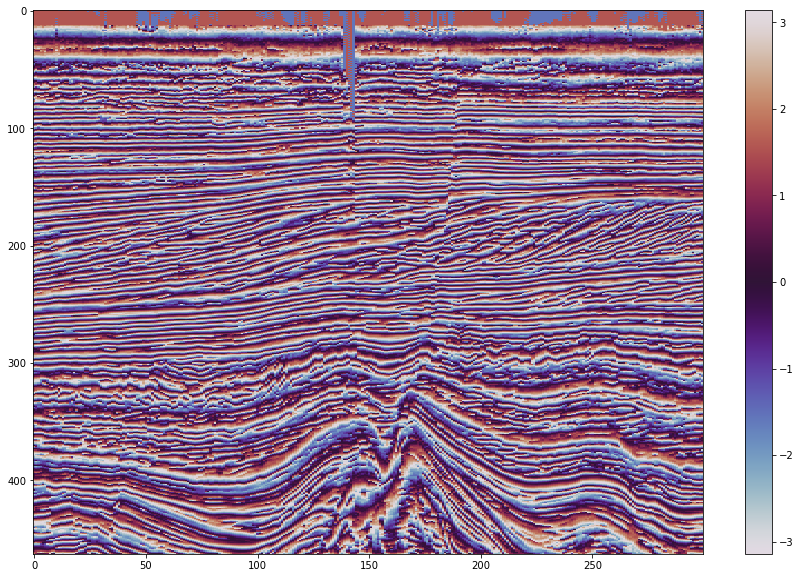

In [17]:
fig, ax = plt.subplots(figsize=(15, 10))
im = ax.imshow(phi[100].T, cmap='twilight', aspect='auto', interpolation='none')
plt.colorbar(im)

## Instantaneous frequency

From [the SciPy docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html)

In [18]:
T = 0.004

# Differentiate the instantaneous phase with respect to time:
instantaneous_frequency = np.diff(phi) / 2.0 * np.pi * 0.004

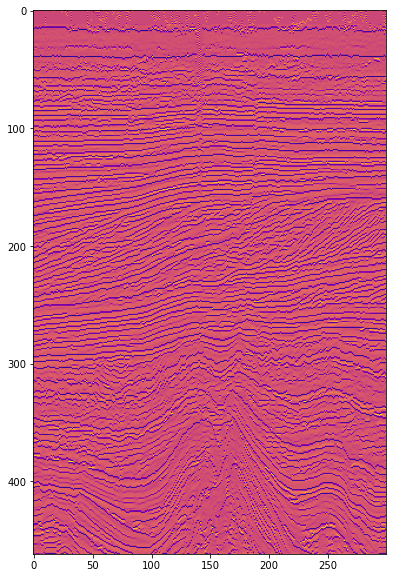

In [19]:
plt.figure(figsize=(15, 10))
plt.imshow(instantaneous_frequency[100].T, cmap='plasma')

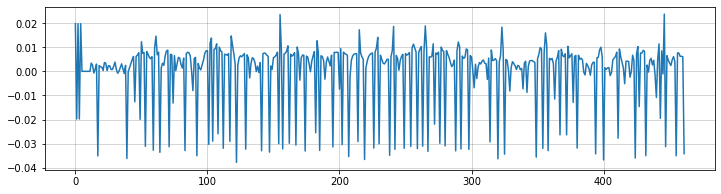

In [20]:
plt.figure(figsize=(12, 3))
plt.plot(instantaneous_frequency[100, 100])
plt.grid(c='k', alpha=0.2)

I am not a fan of this, whatever it is.

## Instantaneous frequency: better estimates

According to Claerbout (1985, _Fundamentals of Geophysical Data Processing_, Blackwell, p20):

$$ f_i(t) = \frac{1}{2\pi} \ \mathrm{Im} \left[\frac{h'(t)}{h(t)} \right] \approx \frac{1}{\pi T} \ \mathrm{Im} \left[\frac{h(t+T) - h(t)}{h(t+T) + h(t)} \right] $$ 

Given that the time interval $T$ is 0.004 s, can you compute this approximation?

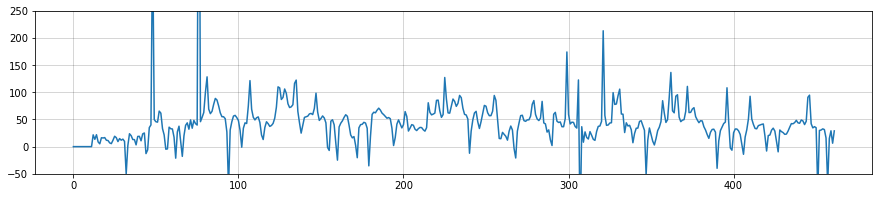

In [21]:
def f_inst_claerbout(h, T):
    """Instantaneous frequency after Claerbout (1985)."""
    return (1 / (np.pi * T)) * np.imag((h[1:] - h[:-1]) / (h[1:] + h[:-1]))

f = f_inst_claerbout(h, T=0.004)

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(f)
ax.set_ylim(-50, 250)
ax.grid(c='k', alpha=0.2)

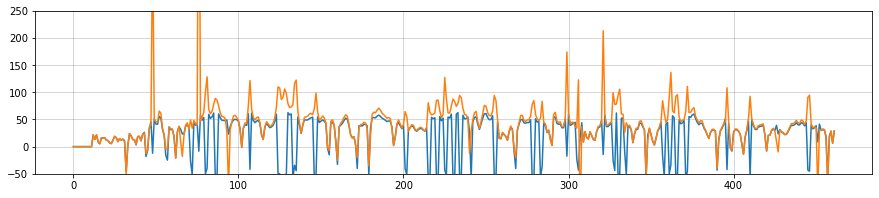

In [25]:
# Scheuer, TE and DW Oldenburg (1988). Local phase velocity from complex seismic data.
# Geophysics 53 (12), p1503. DOI: http://dx.doi.org/10.1190/1.1442431.

def f_inst_scheuer_oldenburg(seismic, T):
    """
    Instantaneous frequency after Claerbout (1985). Provide the
    seismic data and the sample interval T in seconds, e.g. 0.004.
    """
    x = seismic  # Use seismic.data if seismic is an xarray.DataArray.
    h = hilbert(x)
    y = np.abs(h) * np.sin(np.log(h).imag)
    expr = (x[:-1] * y[1:] - x[1:] * y[:-1]) / (x[:-1] * x[1:] + y[1:] * y[:-1])
    return (1 / (2 * np.pi * T)) * np.arctan(expr)

f_so = f_inst_scheuer_oldenburg(tr, T=0.004)

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(f_so, label='Scheuer & Oldenburg')
ax.plot(f, label='')
ax.set_ylim(-50, 250)
ax.grid(c='k', alpha=0.2)

These functions are also implemented in `bruges` (since v0.4.5):

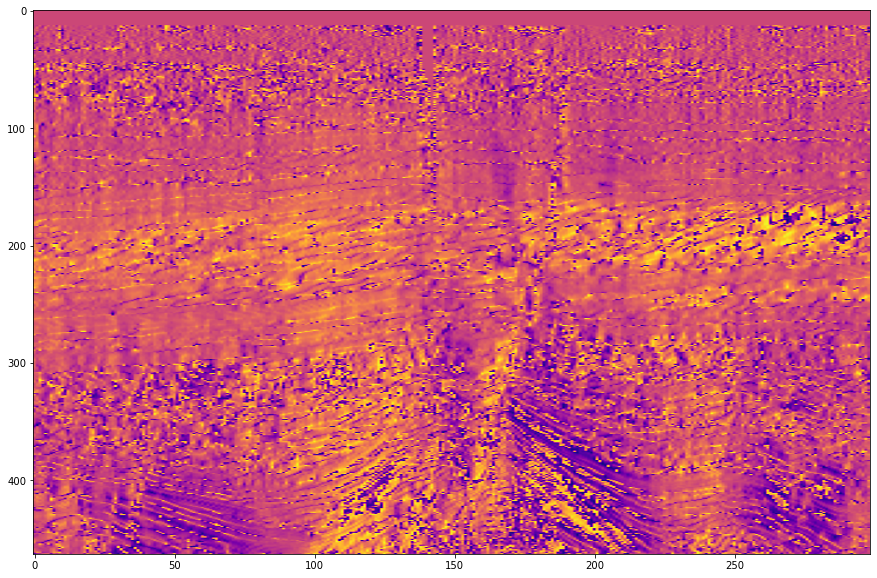

In [26]:
import bruges as bg
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.imshow(bg.attribute.instantaneous_frequency(seismic[100], dt=0.004).T, cmap='plasma', aspect='auto')

For more on Fourier frequency, which does bring with it some challenges around resolution, see the notebook on spectral decomposition.

## Horizons

These will be much easier if we turn the seismic and horizon(s) into an `xarray.DataArray`:

In [28]:
import xarray as xr

il, xl, ts = seismic.shape

inlines = np.arange(il) + 1000
xlines = np.arange(xl) + 1000
time = np.arange(ts) * 0.004

s = xr.DataArray(seismic,
                 name='amplitude',
                 coords=[inlines, xlines, time],
                 dims=['inline', 'xline', 'twt'],
                )

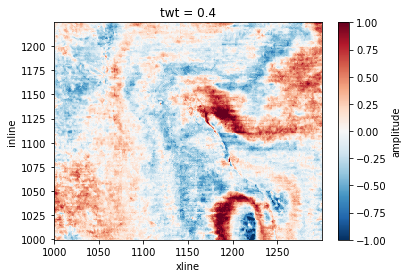

In [37]:
s.sel(twt=0.4).plot()

plt.savefig('timeslice_example.png', dpi=250)

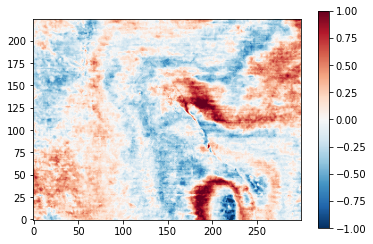

In [36]:
plt.imshow(seismic[:, :, 100], cmap='RdBu_r', origin='lower')
plt.colorbar()
# amplitude
# title
# xlabel
# ylabel
# xticks
#yticks

In [ ]:
import numpy as np

ds = np.DataSource('../data/')

horizon = np.load(ds.open('https://geocomp.s3.amazonaws.com/data/F3_horizon.npy', mode='rb'))

s.shape, horizon.shape

### EXERCISE

Make a `DataArray` for the horizon, and plot it as a map.

Can you plot a 2D seismic section with the horizon?

In [ ]:
h = xr.DataArray(horizon,
                 name='twt',
                 coords=[inlines, xlines],
                 dims=['inline', 'xline'],
                )
h.plot()

In [ ]:
s.sel(inline=1100).T.plot.imshow(origin='upper')
h.sel(inline=1100).plot(c='r')

It's very easy to get the (linear) interpolated amplitude out of the volume now:

In [ ]:
amp = s.interp(twt=h)

amp.plot()

### EXERCISE

Create a plot showing the instantaneous attributes computed on this horizon.

---
&copy; 2021 Agile Scientific &mdash; licenced CC BY and Apache 2.0